In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [ ]:
# in case you don't have the packages installed already, uncomment the following

# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install astropy
# !{sys.executable} -m pip install pycbc

In [32]:
from astropy.cosmology import Planck18
from astropy import constants
import astropy.units as u
import pycbc.psd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Day 1

Using 
\begin{equation}
    \Omega_{GW}(f) = \frac{f}{\rho_{c,0}H_0}\int^\infty_0 dz\frac{R_V(z)}{(1+z)\sqrt{\Omega_{M,0}(1+z)^3+\Omega_{\Lambda,0}}}\frac{dE}{df}\bigg|_{f(1+z)}
\end{equation}
we compute the SGWB frequency spectrum for astrophysical SGWB models.

For CBCs, 
\begin{align}
    \frac{dE}{df} & = \frac{\pi^{2/3}G^{2/3}f^{-1/3}}{3}\int d\mathcal{M}\mathcal{M}^{5/3}P_c(\mathcal{M}) \\
    R_\star(z) & = \nu \frac{a\exp(b(z-z_m))}{a-b+b\exp(a(z-z_m))}
\end{align}

where $R_\star(z)$ is the star formation rate (SFR) with $\nu=23.9\text{yr}^{-1}\text{Gpc}^{-3}, a = 2.80, b = 2.46, z_m = 1.72$. 

To account for the time delay between binary formation and its merger time, 
\begin{equation}
    R_V(z) = \lambda\int_{t_{min}}^{t_{max}}dt_d R_\star(t(z)-t_d)P(t_d)
\end{equation}

To start with, we shall consider the SFR to be a direct proxy for the merger rate $R_V(z)$, i.e. we shall compute $\Omega_{GW}$ without timedelay considerations.

#### Define the star formation rate

In [33]:
def Rstar_z(z):
    """
    The star formation rate as a function of redshift.
    Normalized to the merger rate from GWTC-2
    https://arxiv.org/abs/2010.14533
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 23.9 / u.yr / u.Gpc ** 3 # BBH merger rate
    return nu * a * np.exp(b * (z - zm)) / (a - b + b * np.exp(a * (z - zm)))

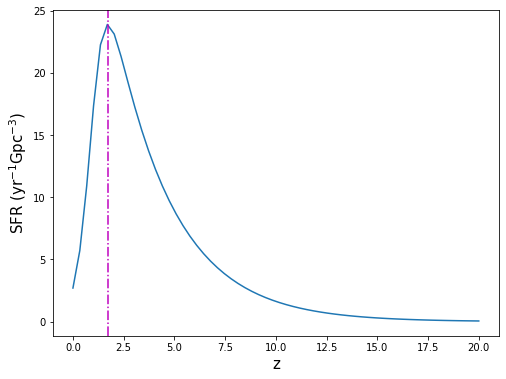

In [34]:
# plotting the SFR
plt.figure(figsize=(8,6))
z = np.linspace(0,20,60)
sfr = Rstar_z(z)
plt.plot(z,sfr)
plt.xlabel('z',size = 15)
plt.ylabel(r'SFR (yr$^{-1}$Gpc$^{-3}$)',size = 15)
plt.axvline(1.72,c='m',ls='-.')
plt.show()

#### Define dE/df

In [35]:
def dEdf(freq, factor):
    """
    Function to calculate dE/df for compact binaries.
    The factor is the integral of the chirp mass distribution
    as defined in the notes.
    """
    
    return  np.pi ** (2/3) * constants.G ** (2/3) * factor * freq ** (-1/3)/(3  * constants.c ** 2)

Text(0, 0.5, 'dE/df')

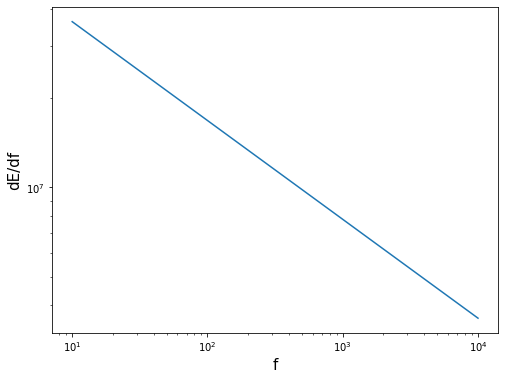

In [36]:
# Plotting dEdf
plt.figure(figsize=(8,6))
f_array = np.linspace(10,1e4)
dedf = dEdf(f_array,30 * constants.M_sun)
plt.loglog(f_array,dedf)
plt.xlabel('f',size = 15)
plt.ylabel('dE/df',size = 15)

#### Define $\Omega_{GW}$ without considering time delay

In [37]:
def omega_GW_without_time_delay(f_arr, chirp_mass_distribution,
                               extra_args=dict()):
    """
    Function to calculate omega_gw given the chirp mass
    distribution. Also takes extra_args that go into the 
    the distribution for chirp mass.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    if chirp_mass_distribution == "delta_function":
        factor = extra_args["val"] ** (5/3) * u.M_sun ** (5/3)
    
    else:
        delta_chirp_mass = 0.1
        chirp_mass_arr = np.arange(0, 200, delta_chirp_mass)
        factor_integrand = chirp_mass_arr ** (5/3) * chirp_mass_distribution(chirp_mass_arr, **extra_args)
        factor = np.sum(factor_integrand) * delta_chirp_mass  * u.M_sun ** (5/3)
        print(factor)
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck18.critical_density0 * Planck18.H0) 
        integrand = Rstar_z(z) / (1 + z) * Planck18.inv_efunc(z) * dEdf(freq * (1 + z), factor) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result

#### A few distributions for chirp mass

In [38]:
def gaussian(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(x - mu) ** 2  / 2 / sigma **2)

def flat(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / (maximum - minimum)
    return y

#### We can now compute $\Omega_{GW}$

498it [00:01, 395.08it/s]
498it [00:01, 407.50it/s]


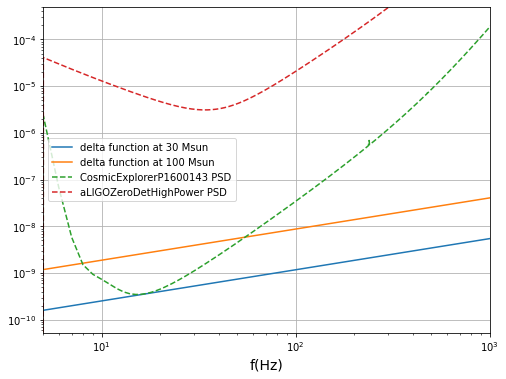

In [39]:
plt.figure(figsize=(8,6))

f_arr = np.arange(5, 1000, 2)
for chirp_mass in [30, 100]:
    omega = omega_GW_without_time_delay(f_arr, "delta_function", extra_args=dict(val=chirp_mass),)
    plt.loglog(f_arr, omega, label=f"delta function at {chirp_mass} Msun")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck18.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")
plt.legend(loc="best")
plt.ylim(ymax=5e-4)
plt.grid()
plt.xlim(5, 1000)
plt.xlabel('f(Hz)',size = 14)
plt.show()